# Pentad Grid System for Bird Atlas Data

This notebook explains the pentad naming convention used in the Southern African Bird Atlas Project (SABAP) and the extended Quarter Degree Grid Cells (QDGC) system.

## Background

The **pentad system** is a 5-minute by 5-minute (5' × 5') geographic grid used for bird atlas data collection. It provides finer spatial resolution than the original Quarter Degree Grid Cells (QDGC).

### Key Features
- **Size**: 5 arcminutes ≈ 0.0833° (~9.3 km × 9.3 km at the equator).
- **Standardization**: Consistent spatial units for comparing observations.
- **Global Coverage**: Unique references across all hemispheres.

## Naming Convention

Each pentad has a unique 9-character ID in the format: `XXYYcZZWW`

- **XX**: Latitude degrees (2 digits)
- **YY**: Latitude minutes (00, 05, ..., 55)
- **c**: Quadrant character indicating hemisphere relative to the Prime Meridian and Equator:
  - `_` (underscore): **NE Quadrant** (Lat ≤ 0, Lng > 0) - e.g., Southern Africa
  - `a`: **SW Quadrant** (Lat ≤ 0, Lng ≤ 0) - e.g., South America
  - `b`: **NW Quadrant** (Lat > 0, Lng ≤ 0) - e.g., North America
  - `c`: **SE Quadrant** (Lat > 0, Lng > 0) - e.g., Europe, Asia
- **ZZ**: Longitude degrees (2 digits)
- **WW**: Longitude minutes (00, 05, ..., 55)

### Edge Cases
Points exactly on the Equator (0° Lat) or Prime Meridian (0° Lng) are assigned to a specific quadrant to ensure every point belongs to exactly one pentad.

---
**Reference**: Larsen, R., Holmern, T., Prager, S.D., Maliti, H., & Røskaft, E. (2009). Using the extended quarter degree grid cell system to unify mapping and sharing of biodiversity data. *African Journal of Ecology*, 47, 382-392.

In [15]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, box
import sys

# Import pentad functions
sys.path.insert(0, '..')
from eBird2ABAP.pentad import *

# Plotting style
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

## Simple Examples

In [16]:
# Example: Convert coordinates to pentad IDs
locations = [
    (-26.2041, 28.0473, "Johannesburg (Southern Africa)"),
    (30.0444, 31.2357, "Cairo (Northern Africa)"),
    (14.7167, -17.4677, "Dakar (Western Africa)"),
    (-1.2921, 36.8219, "Nairobi (East Africa)"),
    (0.0000, 0.0000, "Origin (0,0)"),
]

print("Location → Pentad ID Conversion")
print("=" * 70)
for lat, lng, name in locations:
    pentad_id = latlng2pentad([lat], [lng])[0]
    center_lat, center_lng = pentad2latlng([pentad_id])
    print(f"{name}")
    print(f"  Coordinates: {lat:.4f}°, {lng:.4f}°")
    print(f"  Pentad ID:   {pentad_id}")
    print(f"  Pentad center: {center_lat[0]:.4f}°, {center_lng[0]:.4f}°")
    print()

Location → Pentad ID Conversion
Johannesburg (Southern Africa)
  Coordinates: -26.2041°, 28.0473°
  Pentad ID:   2610_2800
  Pentad center: -26.2083°, 28.0417°

Cairo (Northern Africa)
  Coordinates: 30.0444°, 31.2357°
  Pentad ID:   3000c3110
  Pentad center: 29.9583°, 31.2083°

Dakar (Western Africa)
  Coordinates: 14.7167°, -17.4677°
  Pentad ID:   1440b1725
  Pentad center: 14.6250°, -17.3750°

Nairobi (East Africa)
  Coordinates: -1.2921°, 36.8219°
  Pentad ID:   0115_3645
  Pentad center: -1.2917°, 36.7917°

Origin (0,0)
  Coordinates: 0.0000°, 0.0000°
  Pentad ID:   0000a0000
  Pentad center: -0.0417°, -0.0417°



Let's visualize how pentads look on an actual map.

In [17]:
def plot_pentads_static(locations, buffer=2.0):
 
    # Extract coordinates
    lats = [loc[0] for loc in locations]
    lngs = [loc[1] for loc in locations]
    
    # Determine map bounds
    min_lat, max_lat = min(lats) - buffer, max(lats) + buffer
    min_lng, max_lng = min(lngs) - buffer, max(lngs) + buffer
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Load world map
    url = 'https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/world-countries.json'
    world = gpd.read_file(url)
    
    # Clip world map to area of interest for better performance/visualization
    # Create a bounding box polygon
    bbox = box(min_lng, min_lat, max_lng, max_lat)
    
    # clip
    area_map = world.clip(bbox)
    if not area_map.empty:
            area_map.plot(ax=ax, color='lightgray', edgecolor='white')

    # Plot pentads and markers
    pentad_data = []
    for lat, lng, name in locations:
        pentad_id = latlng2pentad([lat], [lng])[0]
        poly = latlng2polygon(lat, lng)
        pentad_data.append({'pentad': pentad_id, 'geometry': poly, 'name': name, 'lat': lat, 'lng': lng})
    
    pentad_gdf = gpd.GeoDataFrame(pentad_data, crs='EPSG:4326')
    
    # Plot pentads
    pentad_gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2, alpha=0.8)
    
    # Plot markers and labels
    ax.scatter(lngs, lats, color='red', marker='*', s=100, zorder=5, label='Locations')
    
    # Annotate
    for idx, row in pentad_gdf.iterrows():
        # Offset label slightly
        ax.annotate(f"{row['name']}\n{row['pentad']}", 
                    (row['lng'], row['lat']), 
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    ax.set_title('Pentad Grid Locations', fontsize=15, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Ensure aspect ratio is correct
    ax.set_aspect('equal')
    
    # Set limits again to be sure
    ax.set_xlim(min_lng, max_lng)
    ax.set_ylim(min_lat, max_lat)
    
    plt.tight_layout()
    return fig, ax

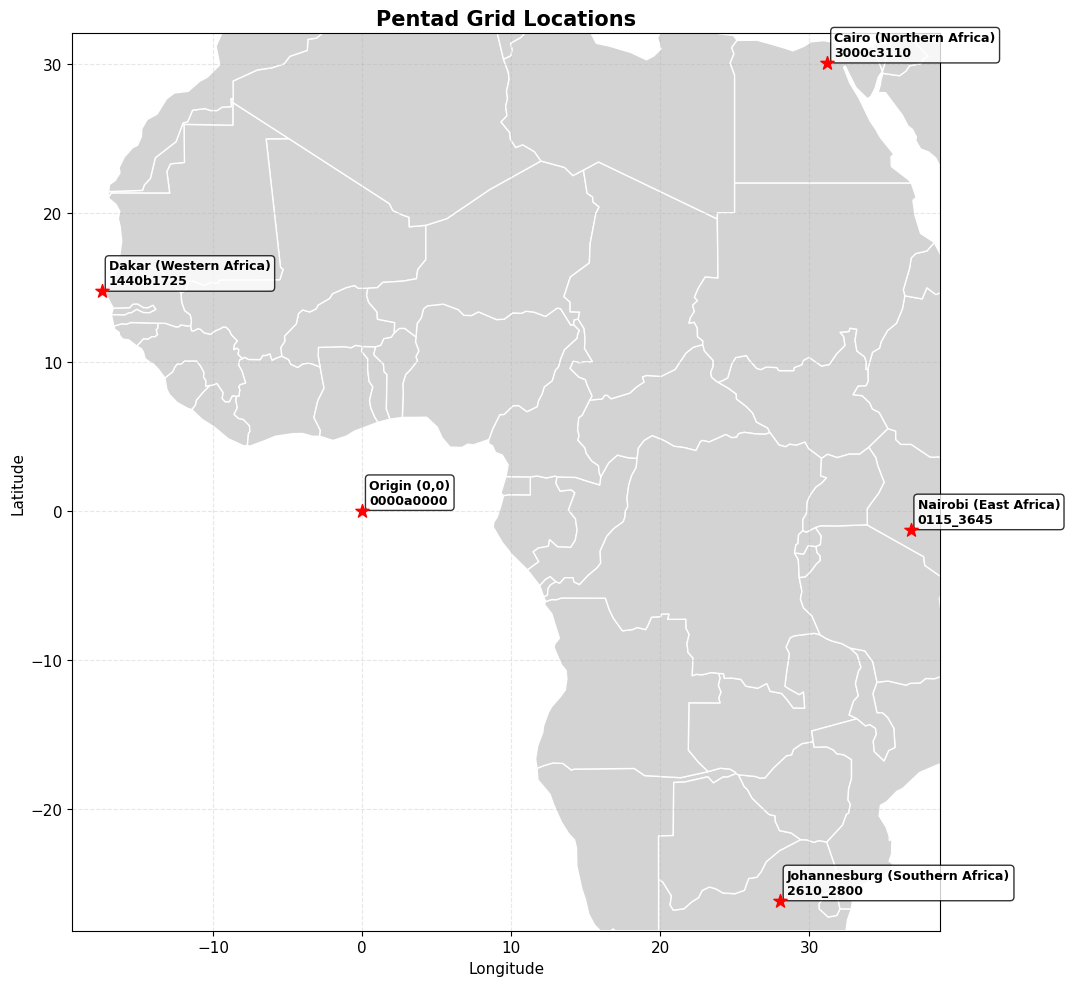

In [18]:
# Generate static map with country borders
fig, ax = plot_pentads_static(locations)
plt.show()

## Edge Cases

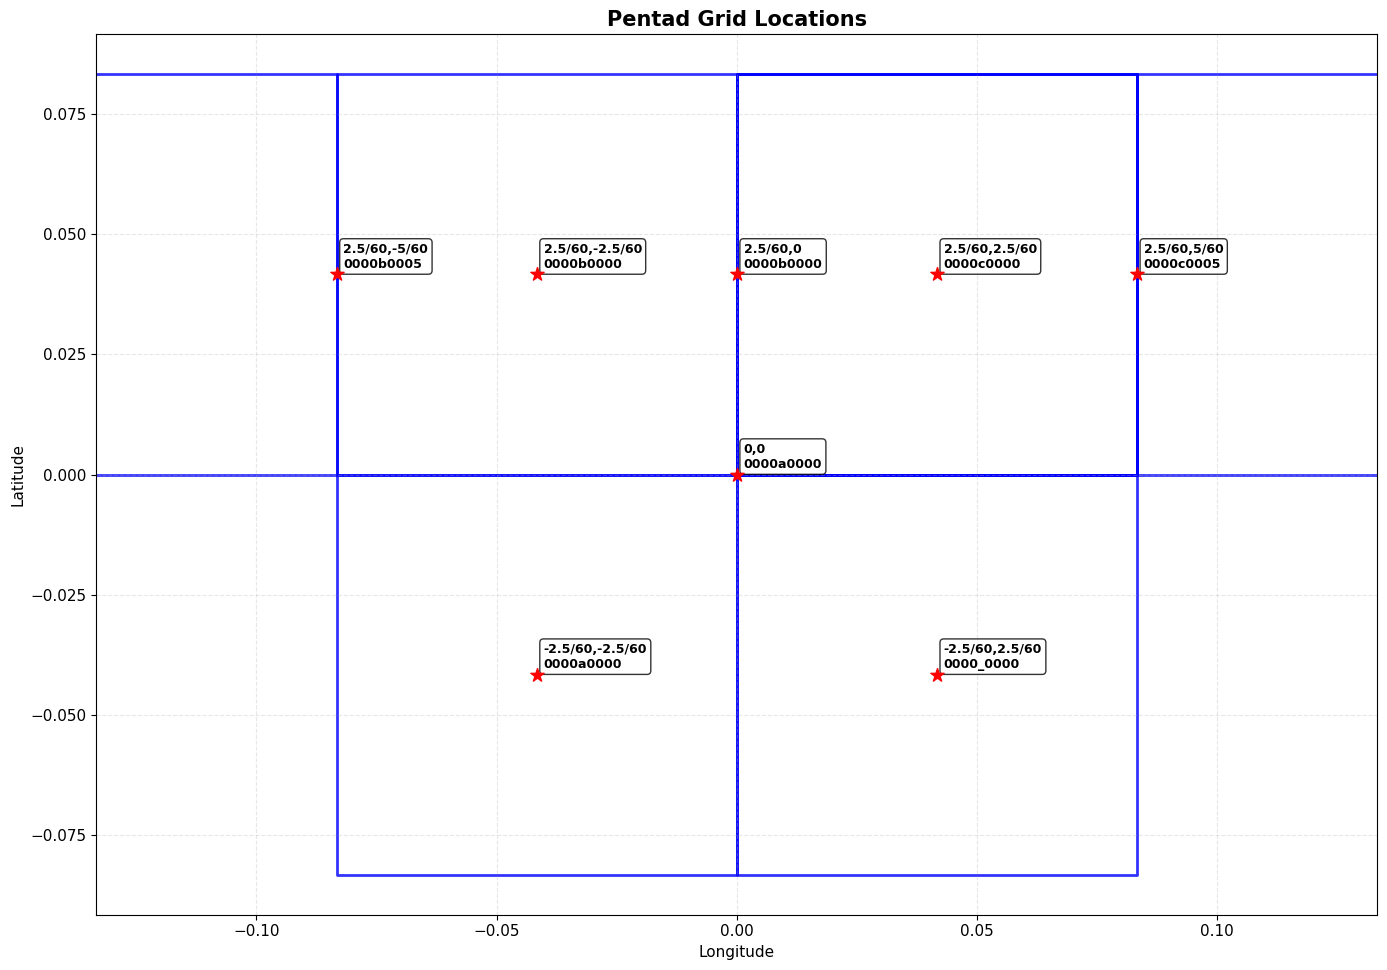

In [29]:
# Define locations to plot
locations_edge_cases = [
    (0, 0, "0,0"),
    (2.5/60, 2.5/60, "2.5/60,2.5/60"),
    (-2.5/60, 2.5/60, "-2.5/60,2.5/60"),
    (-2.5/60, -2.5/60, "-2.5/60,-2.5/60"),
    (2.5/60, -2.5/60, "2.5/60,-2.5/60"),
    (2.5/60, 0, "2.5/60,0"),
    (2.5/60, -5/60, "2.5/60,-5/60"),
    (2.5/60, 5/60, "2.5/60,5/60"),
]
# Generate static map with country borders
fig, ax = plot_pentads_static(locations_edge_cases, buffer=0.05)
plt.show()

## Pentad Size Variation with Latitude

Due to Earth's curvature, pentad cells become narrower (east-west) at higher latitudes while maintaining constant height (north-south).

Pentad Dimensions (Metric Projection):


,Location,Latitude,Width (km),Height (km),Area (km²)
0,Johannesburg (Southern Africa),-26.2041°,8.331,9.233,76.893
1,Cairo (Northern Africa),30.0444°,8.041,9.238,74.245
2,Dakar (Western Africa),14.7167°,8.976,9.220,82.750
3,Nairobi (East Africa),-1.2921°,9.274,9.215,85.459
4,"Origin (0,0)",0.0000°,9.277,9.215,85.480


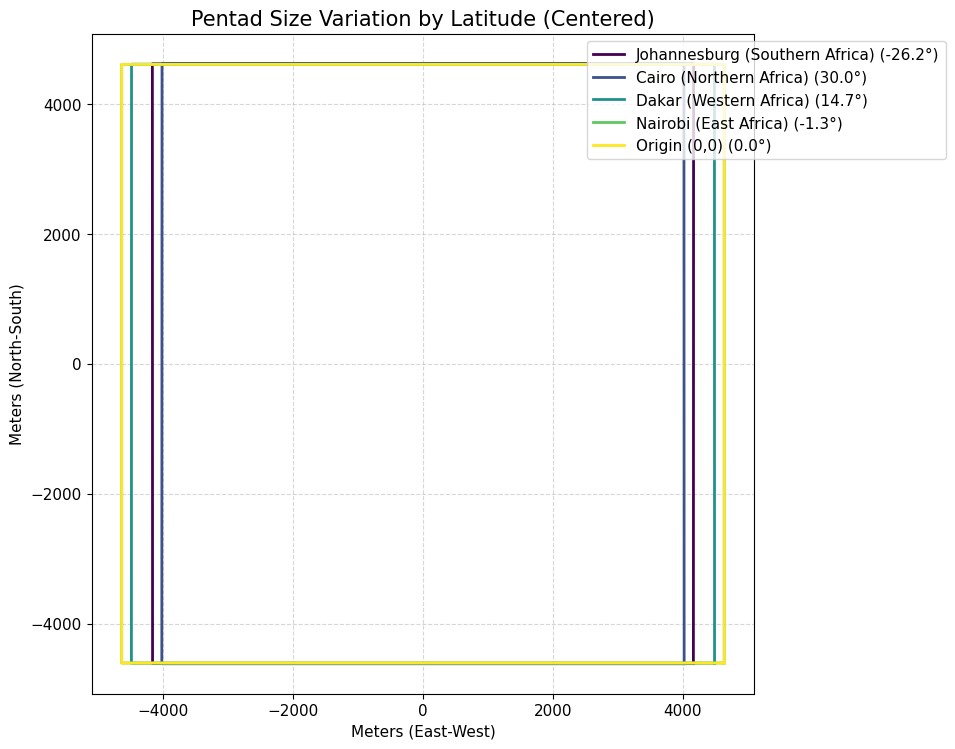

In [20]:
from IPython.display import display
import pandas as pd
import matplotlib.patches as mpatches

def compare_pentad_sizes_metric(locations):
    """
    Compare the physical size (in meters) of pentads at different latitudes.
    Projects each pentad to a local metric CRS centered on itself to minimize distortion.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(locations)))
    
    data = []
    legend_patches = []
    
    for (lat, lng, name), color in zip(locations, colors):
        # Get pentad polygon (WGS84)
        # We use latlng2polygon to get the exact geometric bounds
        poly_wgs84 = latlng2polygon(lat, lng)
        
        # Calculate centroid manually from bounds to avoid GeoPandas warning
        # about centroid in geographic CRS.
        minx, miny, maxx, maxy = poly_wgs84.bounds
        center_x = (minx + maxx) / 2
        center_y = (miny + maxy) / 2
        
        # Create a GeoSeries
        gs = gpd.GeoSeries([poly_wgs84], crs="EPSG:4326")
        
        # Project to Azimuthal Equidistant centered on the pentad center
        # This preserves distances and area reasonably well for small objects
        aeqd_crs = f"+proj=aeqd +lat_0={center_y} +lon_0={center_x} +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
        gs_metric = gs.to_crs(aeqd_crs)
        
        poly_metric = gs_metric.iloc[0]
        minx_m, miny_m, maxx_m, maxy_m = poly_metric.bounds
        width_km = (maxx_m - minx_m) / 1000
        height_km = (maxy_m - miny_m) / 1000
        area_km2 = poly_metric.area / 1e6
        
        # Append to data list
        data.append({
            'Location': name,
            'Latitude': f"{lat:.4f}°",
            'Width (km)': width_km,
            'Height (km)': height_km,
            'Area (km²)': area_km2
        })
        
        # Plot
        # We plot the projected polygon. Since we centered the projection on the centroid,
        # they will all be roughly centered at (0,0).
        # We plot individually to handle colors easily, but legend needs proxy artists
        # or we can just use the label argument if we plot using standard matplotlib plot on the exterior
        x, y = poly_metric.exterior.xy
        ax.plot(x, y, color=color, linewidth=2, label=f"{name} ({lat:.1f}°)")
        
    # Create DataFrame and display
    df = pd.DataFrame(data)
    # Format floats for nicer display
    pd.options.display.float_format = '{:,.3f}'.format
    print("Pentad Dimensions (Metric Projection):")
    display(df)
    
    ax.set_title("Pentad Size Variation by Latitude (Centered)", fontsize=15)
    ax.set_xlabel("Meters (East-West)")
    ax.set_ylabel("Meters (North-South)")
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    return fig, ax

# Run comparison
compare_pentad_sizes_metric(locations)
plt.show()

### Reference

Larsen, R., Holmern, T., Prager, S.D., Maliti, H., & Røskaft, E. (2009). Using the extended quarter degree grid cell system to unify mapping and sharing of biodiversity data. *African Journal of Ecology*, 47(3), 382-392.